In [8]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

In [9]:
with open('order_dict.json') as f:
    data = json.load(f)
with open('capstone_jd_msom_data-minus-click-data/warehouse_capacity.json') as f2:
    warehouse_capacity = json.load(f2)

In [10]:
capacity = {int(k):v[1] for k, v in warehouse_capacity.items()}

In [11]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [12]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [13]:
def r2_loss(outputs, targets):
    target_mean = torch.mean(targets)
    ss_tot = torch.sum((targets - target_mean) ** 2)
    ss_res = torch.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def r2_loss_2(outputs, targets):
    ss_tot = 0.0
    ss_res = 0.0
    target_mean = torch.mean(targets)
    for i in range(0,len(outputs)):
        ss_tot += (targets[i] - target_mean) ** 2
        ss_res += (targets[i] - outputs[i]) ** 2
    r2 = 1 - ss_res / ss_tot
    return r2

# TODO: need to work with tensor objects.
def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = capacity_i / 31 # capacity_i is defined outside of this function
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
        mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    return spo_loss + 0.1 * mse_loss
 
# print(torch.Tensor.float(1.0))
outputs = torch.randn(5)
targets = torch.randn(5)
# print(outputs.size())
# for i in range(0,len(outputs)):
#   print(2)
print(r2_loss(outputs,targets))
print(r2_loss_2(outputs,targets))
#print(SPOLoss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor(-1.0852)
tensor(-1.0852)


In [14]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [15]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO" or "SPO_MSE", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # break loop if percent changae in loss is less than 0.1%
        if (len(loss_list) > 300) and (abs((loss.data - loss_list[-1])/loss_list[-1]) <0.0001):
            loss_list.append(loss.data)
            break
            
        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(len(loss_list)),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt.show()
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    SPO_MSE = SPO_MSE_Loss(y_pred, y_true)
    SPO_MSE_mean = SPO_MSE / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO_MSE_Weighted_Loss':SPO_MSE, 'SPO_MSE_Weighted_Loss Ave': SPO_MSE_mean, 'SPO Loss Ave': SPO_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [16]:
import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 301
        grid = 10**-np.linspace(0,1,11) if regularize == 'l2' else 10**-np.linspace(0,5,11)
        #grid = 10**-np.linspace(-1,5,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 3001
        grid = 10**-np.linspace(-1,5,11)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(aveloss.keys(), aveloss.values())
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    print('The best penalty coefficient is '+ str(best))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    return best

In [17]:
x_train.shape

(198, 35)

In [18]:
i = 1
x_train, y_train, x_test, y_test = preprocessing(order_dict[i])
capacity_i = capacity[i]
#capacity_i = 1000

In [19]:
#cross_validate(x_train, y_train, 'MSE', 'l2')

In [20]:
#cross_validate(x_train, y_train, 'MSE', 'l1')

In [21]:
#cross_validate(x_train, y_train, 'SPO', 'l2')

In [22]:
#cross_validate(x_train, y_train, 'SPO', 'l1')

## MSE loss models

### MSE loss model training

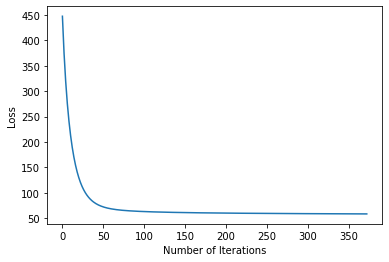

model trained using MSE loss
y-intercept  14.353525161743164
Coefficients  [[-4.6139774e-01 -2.5464484e-02 -1.8902974e-01  3.6948532e-01
   1.0144584e+00  1.7949651e-01 -7.4817681e-01 -4.5199409e-01
   8.5450387e-01  2.6085708e-01  1.8972995e+00  4.5746121e+00
  -4.6552387e-01  6.7232531e-01  6.1233754e+00 -1.7696263e-02
   1.2122326e+00 -1.2888867e+00 -1.7357680e+00  5.5267744e+00
   3.2884848e+00  2.1755860e+00  6.2608552e+00 -5.8973231e+00
  -5.9211987e-01  2.6566308e+00  2.9775994e-02  6.5012628e-01
   3.9276537e-01  2.4297582e-03  4.1267571e-01  2.2288547e+00
   7.1926689e-01 -3.9192212e-01 -3.3759382e-01]]
Train MSE = 58.564513737136906
Train R^2 = 0.7616159874602688
Train SPO Loss = [2062.48077816]


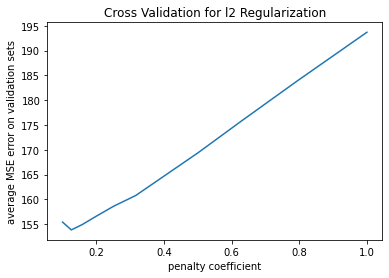

The best penalty coefficient is 0.12589254117941673
Time:  5.614105728999903


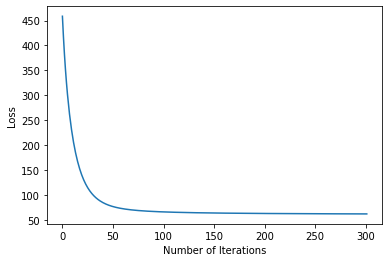

model trained using MSE loss
y-intercept  13.503510475158691
Coefficients  [[-0.38204646  0.02588242 -0.18374749  0.22773711  0.5207156   0.2842567
  -0.31085062 -0.6920096   1.0127689   0.05007361  1.4474593   3.0832038
  -0.4452382   0.9550975   5.6339216  -0.3484288   1.3552307  -1.0510222
  -1.5418373   5.2125964   2.3993537   1.5477753   5.9160123  -4.555638
  -0.8531132   2.2336285  -0.06945132  0.36732382  0.162582   -0.01560738
   0.32948723  2.1178343   0.61462504 -0.4117903  -0.36000663]]
Train MSE = 61.682770355602365
Train R^2 = 0.7489232751434756
Train SPO Loss = [1902.30630672]


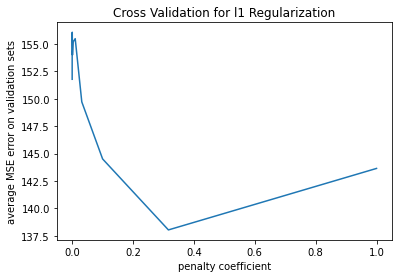

The best penalty coefficient is 0.31622776601683794
Time:  7.96956220900006


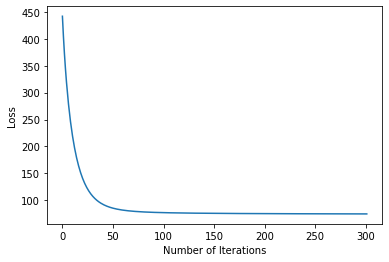

model trained using MSE loss
y-intercept  14.353472709655762
Coefficients  [[-1.0933418e-01  6.5664412e-03  1.1564040e-03  9.8414943e-03
   1.3635415e-03  1.4358473e-01 -1.0133710e-02 -4.7533172e-01
   1.0573949e+00 -8.4441184e-04  5.1891321e-01  3.1000566e+00
  -4.0483448e-01  8.6645454e-01  6.4557819e+00 -2.7721438e-01
   1.0086864e+00 -1.4206702e-01 -8.1429714e-01  5.7151837e+00
   2.5542448e+00  1.4316376e+00  6.3051586e+00 -4.4613757e+00
  -6.6130579e-01  1.8767537e+00 -1.8184769e-03  1.7522568e-01
  -5.6883215e-04  3.0923041e-03  1.7777847e-01  2.0025485e+00
   4.5996290e-01 -2.5737980e-01 -1.9914906e-01]]
Train MSE = 61.44161623303793
Train R^2 = 0.7499048813023763
Train SPO Loss = [2062.36085584]


In [23]:
# ols model training

learningRate = 0.02
epochs = 501

model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None')

# ridge regression (l2 regrularization)

best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2')
model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2)

# l1 regularization (lasso) - penalty coefficient set to be 0.1

best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1)

### MSE loss model evaluation

In [24]:
# compile results for models trained on MSE loss
MSE_result = []

for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    MSE_result.append(pd.concat({name:score_df}))
    
MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])
MSE_scores

MSE       R^2     SPO Loss  SPO_MSE_Weighted_Loss  \
mse_ols   train  58.564514  0.761616  2062.480778            2068.337230   
          test   63.220897  0.609495   625.041361             631.363451   
mse_ridge train  61.682770  0.748923  1902.306307            1908.474584   
          test   60.305174  0.627505   558.361645             564.392162   
mse_lasso train  61.441616  0.749905  2062.360856            2068.505017   
          test   58.109599  0.641067   579.296828             585.107788   

                 SPO_MSE_Weighted_Loss Ave  SPO Loss Ave  
mse_ols   train                  10.446148     10.416570  
          test                   11.076552     10.965638  
mse_ridge train                   9.638761      9.607608  
          test                    9.901617      9.795818  
mse_lasso train                  10.446995     10.415964  
          test                   10.265049     10.163102

## SPO loss models

### SPO loss model training

/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


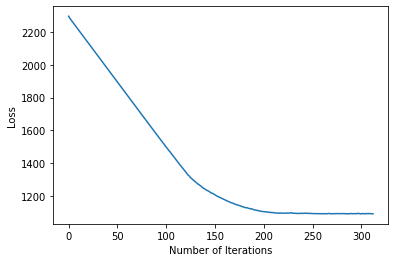

model trained using SPO loss
y-intercept  8.556571006774902
Coefficients  [[ 0.20309038  0.21172072  0.44738266  0.17412688  0.10800243  0.06298971
   0.15559039  0.0522481  -0.12005755  0.30389935  1.6994814   1.9778484
   0.19064714  3.0485604   1.8015807  -0.3908494   2.400049   -1.1519104
  -1.3304394   4.3703647   0.42568415  1.1563692   1.8456959  -2.3914146
  -0.27892047  0.92467546  0.3005884   0.436599   -0.00511702 -0.03982522
   0.00820612  0.27635658 -0.02010178 -0.6311318  -1.2509929 ]]
Train MSE = 149.3857336000893
Train R^2 = 0.3919326172224513
Train SPO Loss = [1091.03236242]


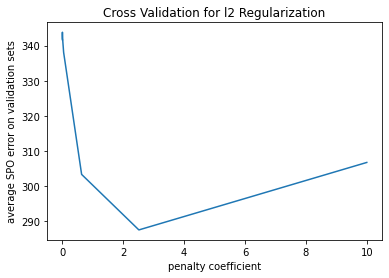

The best penalty coefficient is 2.51188643150958
Time:  218.44916681899986


/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


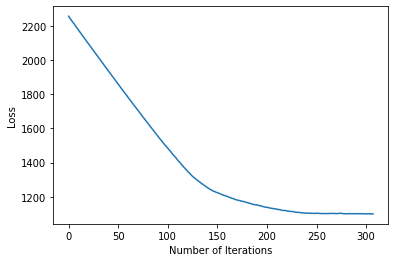

model trained using SPO loss
y-intercept  8.495933532714844
Coefficients  [[ 1.0404834e-01 -2.9598497e-02  2.8454876e-01  1.0119870e-01
  -1.3625880e-01  1.7425559e-02  2.8398329e-01 -2.2373542e-03
   1.4493526e-02  1.6980067e-01  1.3421007e+00  1.4013959e+00
   1.3632402e-01  2.2828038e+00  1.8845019e+00 -5.4062223e-01
   2.1912313e+00 -9.2013854e-01 -1.1786599e+00  4.2944694e+00
   9.4004190e-01  1.1668421e+00  1.8598586e+00 -2.0196230e+00
  -4.2867270e-01  8.2661688e-01  2.9071063e-01  3.5573313e-01
   1.1060378e-01  1.3877723e-01  9.2304491e-02  3.4931263e-01
   8.4353216e-02 -5.7667011e-01 -9.8659903e-01]]
Train MSE = 152.34773303484027
Train R^2 = 0.37987594219283183
Train SPO Loss = [1098.90710721]


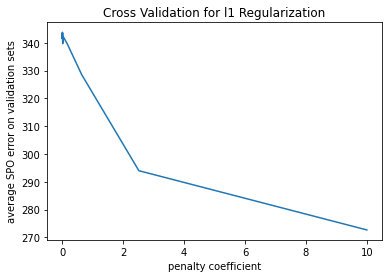

The best penalty coefficient is 10.0
Time:  213.90771173299981


/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


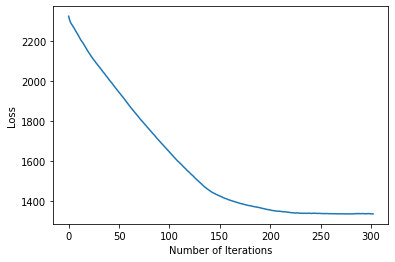

model trained using SPO loss
y-intercept  8.465068817138672
Coefficients  [[-1.4709113e-02  2.1969667e-04  1.3920553e-02  3.2386181e-01
   4.4895904e-03 -1.5879681e-02  1.3604766e-01 -3.8475776e-03
   4.5626462e-01 -8.0319438e-03  1.9339468e-01  2.1931656e-02
  -1.7190399e-02  2.8741496e+00  2.2252553e+00 -3.4809172e-01
   2.0424318e+00 -2.4986029e-02 -5.7579625e-01  4.6487160e+00
   1.5988058e-01  2.3058992e-02  3.8093975e-01 -1.0198261e+00
  -4.4431064e-01  5.5320088e-02  1.6527230e-02  9.8144105e-03
  -1.4335608e-02  2.0821705e-02  9.7151063e-02  1.7314158e-01
   1.4800006e-01 -3.1963971e-01 -3.6360651e-01]]
Train MSE = 176.38944142473852
Train R^2 = 0.2820153343165672
Train SPO Loss = [1162.70187495]


In [25]:
# ols

learningRate = 0.05
epochs = 3001

# model training
model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None')

# ridge regression (l2 regrularization)

best_l2_spo = cross_validate(x_train, y_train, 'SPO', 'l2')
model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2_spo) #2.3357

# l1 regularization (lasso)

best_l1_spo = cross_validate(x_train, y_train, 'SPO', 'l1')
model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = best_l1_spo) #10

### SPO loss model evaluation

In [26]:
capacity[1]/31

33.225806451612904

In [30]:
# compile results for models trained on SPO loss
SPO_result = []

for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores.iloc[:,[0,1,2,5]] # 43 47 43

MSE       R^2     SPO Loss  SPO Loss Ave
spo_ols   train  149.385734  0.391933  1091.032362      5.510264
          test    98.703519  0.390325   407.357947      7.146631
spo_ridge train  152.347733  0.379876  1098.907107      5.550036
          test    99.010974  0.388426   395.340263      6.935794
spo_lasso train  176.389441  0.282015  1162.701875      5.872232
          test    93.302632  0.423686   344.400252      6.042110

In [28]:
MSE_scores.iloc[:,[0,1,2,5]]

MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train  58.564514  0.761616  2062.480778     10.416570
          test   63.220897  0.609495   625.041361     10.965638
mse_ridge train  61.682770  0.748923  1902.306307      9.607608
          test   60.305174  0.627505   558.361645      9.795818
mse_lasso train  61.441616  0.749905  2062.360856     10.415964
          test   58.109599  0.641067   579.296828     10.163102

# References

In [29]:
%%script false --no-raise-error
import time
# Batch Gradient Descent Using Numpy - For comparison purpose

"""
code is based on Yuhan Cheng's code, approved use
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = np.zeros((xvalue_matrix.shape[1],))
    epsilon = 0.00001
    n = float(len(xvalue_matrix))
    loss = []
    for i in range(MaxIterations):
        # compute new coefficients
        y_pred = alpha + np.matmul(xvalue_matrix, beta)
        loss.append(mean_squared_error(y_pred,yvalues))
#         if i % 100 == 0:
#             print('Current Loss:', loss)
        d_alpha = np.mean(y_pred - yvalues)
        d_beta = np.mean((y_pred - yvalues) * xvalue_matrix.T, axis = 1)
        alpha_1 = alpha - (R * d_alpha)
        beta_1 = beta - (R * d_beta)
        
        if np.isnan(alpha_1):
            print('nan at iter', str(i))
            break
        
        # check to see whether stopping criteria has been met
        if (np.abs(alpha_1-alpha)<epsilon) and np.all(np.abs(beta_1-beta)<epsilon):
            alpha, beta = alpha_1, beta_1
            print('error < epsilon, criteria met')
            break
        alpha, beta = alpha_1, beta_1
            
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('MSE:', str(loss[-1]))
    print('R2:', str(r2_score(y_true=yvalues, y_pred = y_pred)))
    
    plt.plot(range(len(loss)),loss)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    return alpha, beta

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
